# Anomaly Detection of ERP Transaction Data

This hands-on mini-project will enable you to reinforce your learnings pertaining to anomaly detection in this unit. By now, you must already be aware of the key objective of anomaly detection. Just to refresh your memory, anomaly detection is the identification of outliers or rare event items in a dataset which potentially exhibit abnormal behavior or properties as compared to the rest of the datapoints.

There are a wide variety of anomaly detection methods including supervised, unsupervised and semi-supervised. Typically you can perform anomaly detection on univariate data, multivariate data as well as data which is temporal in nature. In this mini-project you will leverage state-of-the-art anomaly detection models from frameworks like [__`scikit-learn`__](https://scikit-learn.org/stable/modules/outlier_detection.html) and [__`PyOD`__](https://pyod.readthedocs.io/en/latest/index.html).


By the end of this mini-project, you will have successfully applied these techniques to find out potential outliers pertaining to sales transactional data in a retail store dataset and also learnt how to visualize outliers similar to the following plot.

![](outlier_ex.png)

We will be performing anomaly detection on both univariate and multivariate data and leverage the following anomaly detection techniques.

- Simple Statistical Models (mean & standard deviation: the three-sigma rule)
- Isolation Forest
- Clustering-Based Local Outlier Factor
- Auto-encoders

# 1. Import Dependencies

In [1]:
!pip install jupyterthemes

In this notebook we'll see how to apply deep neural networks to the problem of detecting anomalies.  Anomaly detection is a wide-ranging and often weakly defined class of problem where we try to identify anomalous data points or sequences in a dataset.  When dealing with time series specifically (such as a sensor or collection of sensors on a piece of equipment), defining something as anomalus needs to take into account temporal dependencies.  This is a challenge that deep learning models are fairly well suited to handle.  We'll start with a simple time series of sensor readings and see how to construct an autoencoder using LTSM's that predict future time steps in the series.  We'll then see how to use the distribution of the model errors to identify points in time that stand out as potentially being anomalus.

The dataset used for this example can be found [here](https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv).  It's part of a collection of datasets that Numenta has hosted to showcase their own anomaly detection methods.

Let's start by getting some imports out of the way and reading the data into a data frame.

In [2]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jupyterthemes import jtplot
jtplot.style()
import seaborn as sns
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/naufalkr/XAI-erp-transaction-anomaly/main/financial_anomaly_data.csv')
df.shape

(217441, 7)

In [4]:
df.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [5]:
df.tail()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
217436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217440,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.count()

,0
Timestamp,216960
TransactionID,216960
AccountID,216960
Amount,216960
Merchant,216960
TransactionType,216960
Location,216960


In [7]:

df.dtypes

,0
Timestamp,object
TransactionID,object
AccountID,object
Amount,float64
Merchant,object
TransactionType,object
Location,object


In [8]:
df.describe()

,Amount
count,216960.000000
mean,50090.025108
std,29097.905016
min,10.510000
25%,25061.242500
50%,50183.980000
75%,75080.460000
max,978942.260000


# 2. Handling Missing Value and Outliers


In [9]:
df.isna().sum()

,0
Timestamp,481
TransactionID,481
AccountID,481
Amount,481
Merchant,481
TransactionType,481
Location,481


In [10]:
value_counts = {column: df[column].value_counts() for column in df.columns}
value_counts

{'Timestamp': Timestamp
 01-01-2023 08:00    1
 11-04-2023 18:57    1
 11-04-2023 18:33    1
 11-04-2023 18:34    1
 11-04-2023 18:35    1
                    ..
 20-02-2023 13:23    1
 20-02-2023 13:24    1
 20-02-2023 13:25    1
 20-02-2023 13:26    1
 31-05-2023 23:59    1
 Name: count, Length: 216960, dtype: int64,
 'TransactionID': TransactionID
 TXN838     139
 TXN1768    139
 TXN1658    139
 TXN1389    138
 TXN340     137
           ... 
 TXN60       79
 TXN891      78
 TXN605      78
 TXN201      73
 TXN799      70
 Name: count, Length: 1999, dtype: int64,
 'AccountID': AccountID
 ACC15    14701
 ACC5     14630
 ACC7     14581
 ACC2     14553
 ACC9     14527
 ACC14    14458
 ACC4     14456
 ACC11    14446
 ACC12    14421
 ACC13    14421
 ACC8     14402
 ACC1     14365
 ACC10    14362
 ACC6     14352
 ACC3     14285
 Name: count, dtype: int64,
 'Amount': Amount
 18010.00    3
 34588.69    3
 74109.74    3
 86099.64    3
 7309.50     3
            ..
 56652.57    1
 36336.36    1

In [11]:
df.isna().sum()

,0
Timestamp,481
TransactionID,481
AccountID,481
Amount,481
Merchant,481
TransactionType,481
Location,481


In [12]:
transaction_counts = df['TransactionType'].value_counts()

# Display the counts
print(transaction_counts)

TransactionType
Transfer      72793
Purchase      72235
Withdrawal    71932
Name: count, dtype: int64


In [13]:
df = df.dropna()
df.isna().sum()

,0
Timestamp,0
TransactionID,0
AccountID,0
Amount,0
Merchant,0
TransactionType,0
Location,0


In [14]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M')
df

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles
...,...,...,...,...,...,...,...
216955,2023-05-31 23:55:00,TXN1286,ACC6,62536.88,MerchantA,Withdrawal,San Francisco
216956,2023-05-31 23:56:00,TXN1015,ACC5,68629.69,MerchantG,Transfer,London
216957,2023-05-31 23:57:00,TXN1979,ACC15,8203.57,MerchantF,Purchase,London
216958,2023-05-31 23:58:00,TXN1845,ACC14,77800.36,MerchantF,Purchase,New York


In [15]:
df.count()

,0
Timestamp,216960
TransactionID,216960
AccountID,216960
Amount,216960
Merchant,216960
TransactionType,216960
Location,216960


In [16]:
df

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles
...,...,...,...,...,...,...,...
216955,2023-05-31 23:55:00,TXN1286,ACC6,62536.88,MerchantA,Withdrawal,San Francisco
216956,2023-05-31 23:56:00,TXN1015,ACC5,68629.69,MerchantG,Transfer,London
216957,2023-05-31 23:57:00,TXN1979,ACC15,8203.57,MerchantF,Purchase,London
216958,2023-05-31 23:58:00,TXN1845,ACC14,77800.36,MerchantF,Purchase,New York


# 3. Exploratory Data Analysise

<Axes: xlabel='Timestamp'>

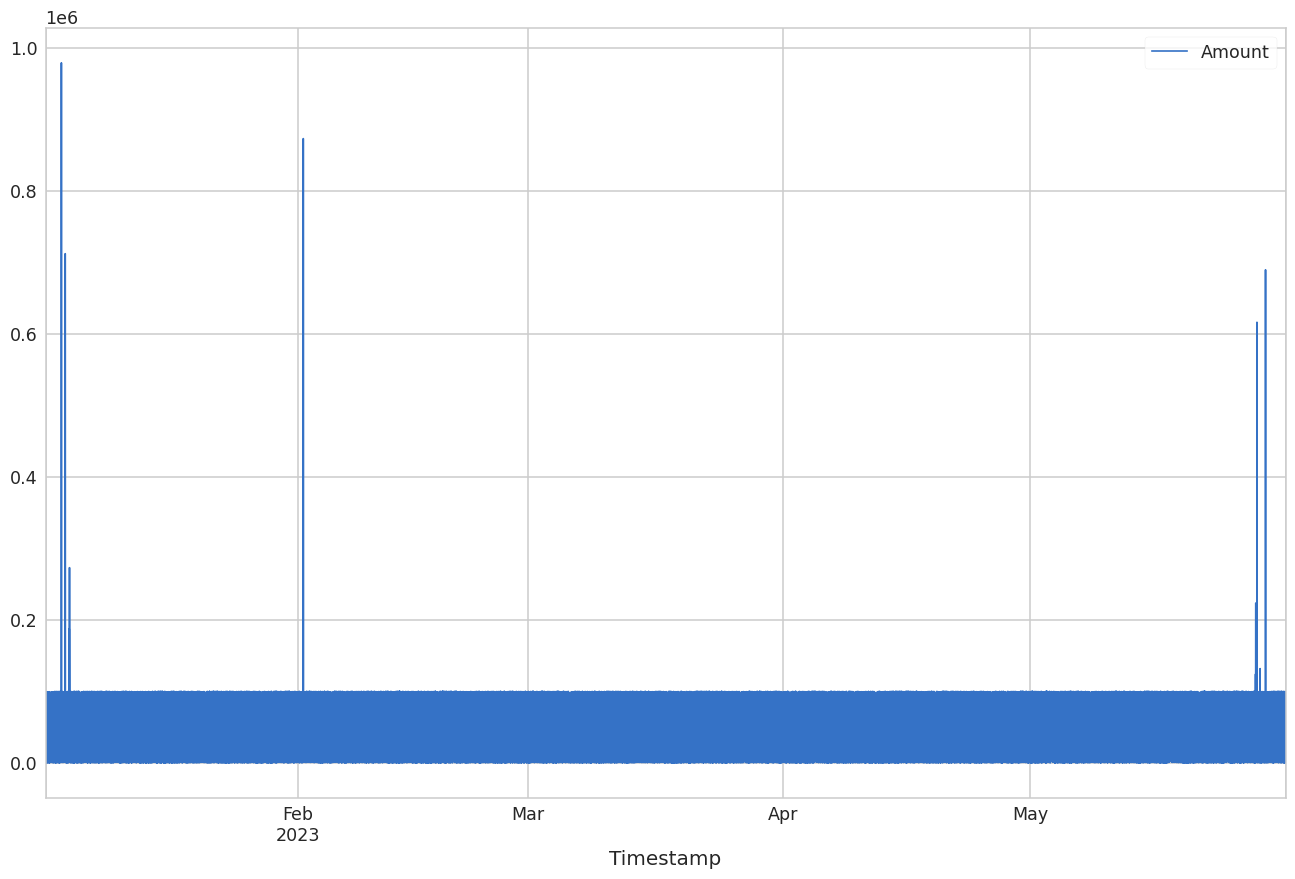

In [17]:
# Transaction based on timestamp
df.set_index('Timestamp').plot(figsize=(16, 10))

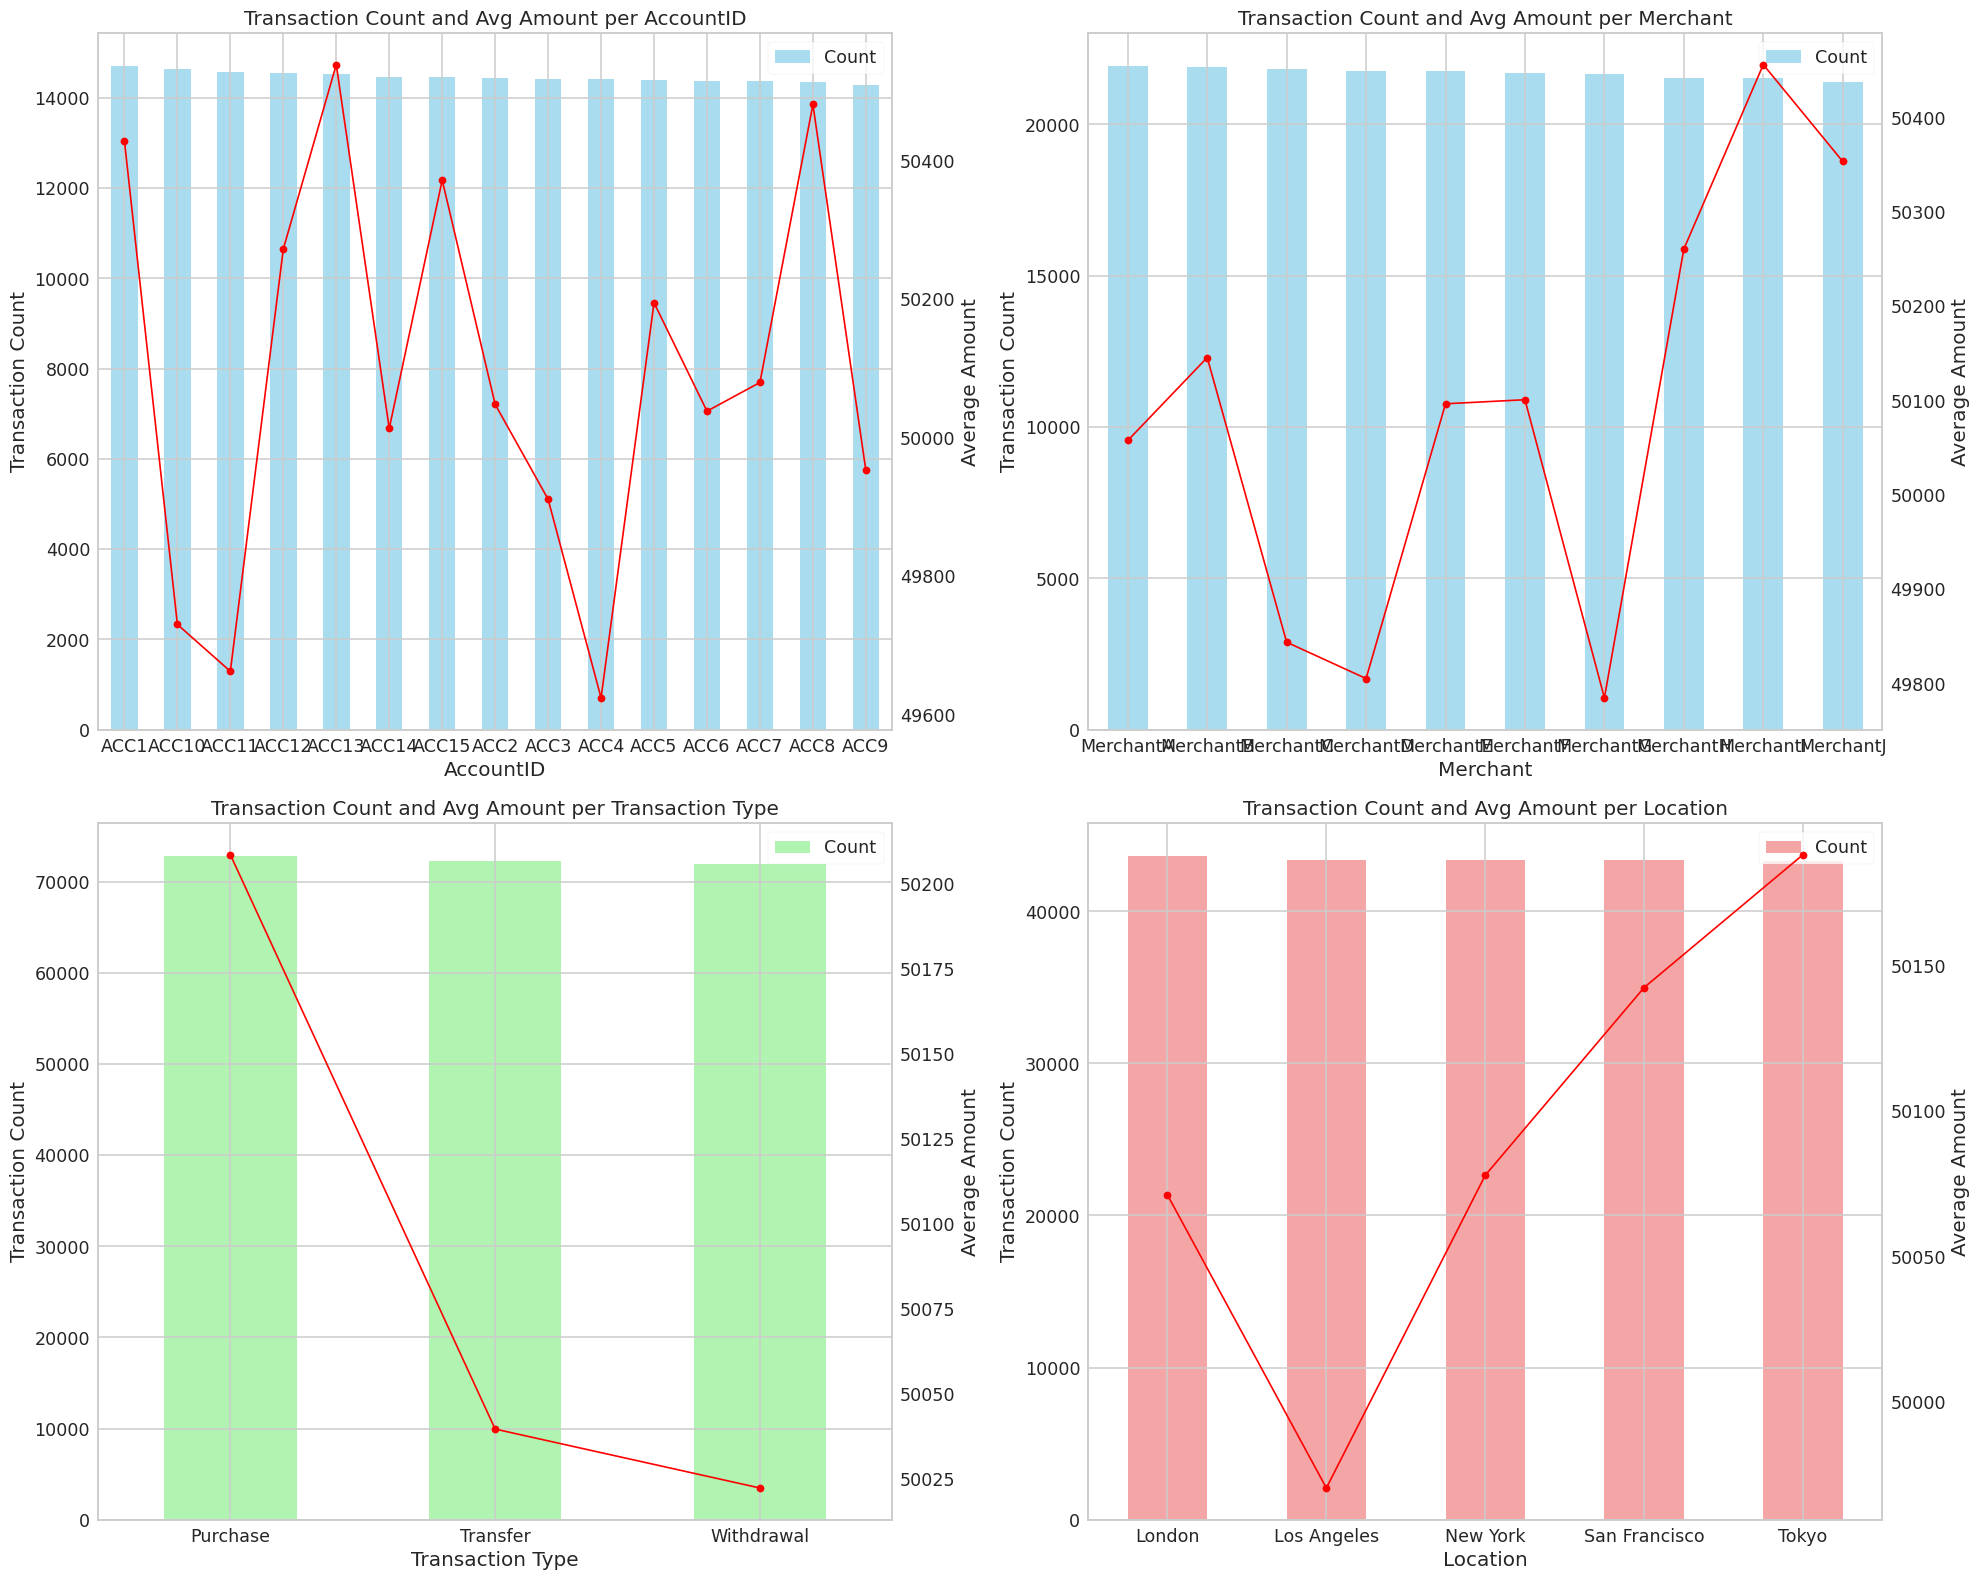

In [18]:
import matplotlib.pyplot as plt

# Set up a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 2: AccountID distribution - Count and Average Amount
AccountID_counts = df['AccountID'].value_counts()
AccountID_avg_amount = df.groupby('AccountID')['Amount'].mean()
AccountID_counts.plot(kind='bar', ax=axes[0, 0], color='skyblue', alpha=0.7, label='Count')
AccountID_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[0, 0], color='red', label='Avg Amount')
axes[0, 0].set_title("Transaction Count and Avg Amount per AccountID")
axes[0, 0].set_xlabel("AccountID")
axes[0, 0].set_ylabel("Transaction Count")
axes[0, 0].right_ax.set_ylabel("Average Amount")
axes[0, 0].legend()

# Plot 2: Merchant distribution - Count and Average Amount
merchant_counts = df['Merchant'].value_counts()
merchant_avg_amount = df.groupby('Merchant')['Amount'].mean()
merchant_counts.plot(kind='bar', ax=axes[0, 1], color='skyblue', alpha=0.7, label='Count')
merchant_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[0, 1], color='red', label='Avg Amount')
axes[0, 1].set_title("Transaction Count and Avg Amount per Merchant")
axes[0, 1].set_xlabel("Merchant")
axes[0, 1].set_ylabel("Transaction Count")
axes[0, 1].right_ax.set_ylabel("Average Amount")
axes[0, 1].legend()

# Plot 3: Transaction Type distribution - Count and Average Amount
type_counts = df['TransactionType'].value_counts()
type_avg_amount = df.groupby('TransactionType')['Amount'].mean()
type_counts.plot(kind='bar', ax=axes[1, 0], color='lightgreen', alpha=0.7, label='Count')
type_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[1, 0], color='red', label='Avg Amount')
axes[1, 0].set_title("Transaction Count and Avg Amount per Transaction Type")
axes[1, 0].set_xlabel("Transaction Type")
axes[1, 0].set_ylabel("Transaction Count")
axes[1, 0].right_ax.set_ylabel("Average Amount")
axes[1, 0].legend()

# Plot 4: Location distribution - Count and Average Amount
location_counts = df['Location'].value_counts()
location_avg_amount = df.groupby('Location')['Amount'].mean()
location_counts.plot(kind='bar', ax=axes[1, 1], color='lightcoral', alpha=0.7, label='Count')
location_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[1, 1], color='red', label='Avg Amount')
axes[1, 1].set_title("Transaction Count and Avg Amount per Location")
axes[1, 1].set_xlabel("Location")
axes[1, 1].set_ylabel("Transaction Count")
axes[1, 1].right_ax.set_ylabel("Average Amount")
axes[1, 1].legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()


# 4. Univariate Anomaly Detection using Statistical Modelin

Univariate is basically analysis done on a single attribute or feature. In this section, we will perform anomaly detection on a single attribute using the following methods.

- Statistical Process Control Methods (mean + 3sigma thresholding)
- Isolation Forest


## 4.1: Univariate Anomaly Detection on Sales using Statistical Modeling

Here we start off by implementing anomaly detecting using statistical modeling on the __`Sales`__ attribute

### Obtain Upper Limit Threshold for AccountID

Here we are concerned about transactions with high sales values so we compute the upper limit using the $\mu$ + 3$\sigma$ rule where $\mu$ is the mean of the distribution and $\sigma$ is the standard deviation of the distribution.

In [19]:
mean_Amount = df['Amount'].mean()
sigma_Amount = df['Amount'].std()
three_sigma_Amount = 3*sigma_Amount

threshold_Amount_value = mean_Amount + three_sigma_Amount
print('Threshold Amount:', threshold_Amount_value)

Threshold Amount: 137383.740154824


### Visualize Outlier Region

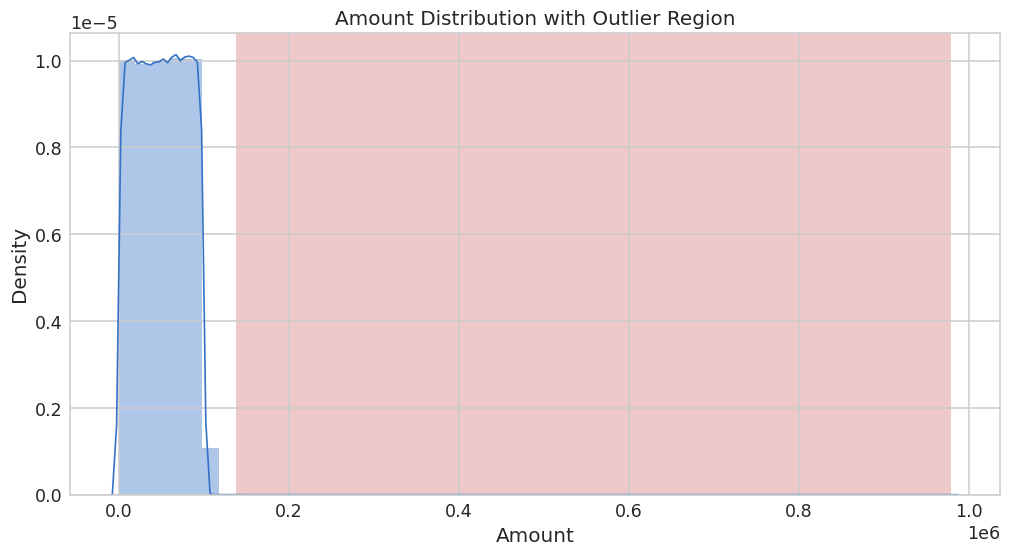

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.distplot(df['Amount'])
plt.axvspan(threshold_Amount_value, df['Amount'].max(), facecolor='r', alpha=0.3)
plt.title("Amount Distribution with Outlier Region");

### Filter and Sort Outliers

Here we filter out the outlier observations and sort by descending order and view the top 5 outlier values

In [21]:
Amount_outliers_df = df['Amount'][df['Amount'] > threshold_Amount_value]
print('Total Amount Outliers:', len(Amount_outliers_df))
Amount_outliers_sorted = Amount_outliers_df.sort_values(ascending=False)
Amount_outliers_sorted.head(5)

Total Amount Outliers: 11


,Amount
2775,978942.26
45100,873004.79
3448,712076.97
213460,689504.90
211959,616155.70


### View Top 10 Outlier Transactions

In [22]:
(df.loc[Amount_outliers_sorted.index.tolist()][['TransactionID', 'AccountID', 'Merchant', 'TransactionType', 'Location']]).head(10)

,TransactionID,AccountID,Merchant,TransactionType,Location
2775,TXN1049,ACC14,MerchantJ,Transfer,New York
45100,TXN190,ACC5,MerchantI,Withdrawal,Los Angeles
3448,TXN827,ACC12,MerchantA,Withdrawal,Tokyo
213460,TXN1249,ACC5,MerchantI,Purchase,San Francisco
211959,TXN1359,ACC8,MerchantC,Purchase,New York
3453,TXN1690,ACC8,MerchantF,Purchase,Tokyo
4194,TXN667,ACC3,MerchantE,Transfer,Los Angeles
211753,TXN141,ACC4,MerchantG,Withdrawal,San Francisco
211866,TXN543,ACC2,MerchantJ,Purchase,San Francisco
4148,TXN625,ACC1,MerchantD,Purchase,San Francisco


### View Bottom 10 Outlier Transactions

In [23]:
(df.loc[Amount_outliers_sorted.index.tolist()][['TransactionID', 'AccountID', 'Merchant', 'TransactionType', 'Location']]).tail(10)

,TransactionID,AccountID,Merchant,TransactionType,Location
45100,TXN190,ACC5,MerchantI,Withdrawal,Los Angeles
3448,TXN827,ACC12,MerchantA,Withdrawal,Tokyo
213460,TXN1249,ACC5,MerchantI,Purchase,San Francisco
211959,TXN1359,ACC8,MerchantC,Purchase,New York
3453,TXN1690,ACC8,MerchantF,Purchase,Tokyo
4194,TXN667,ACC3,MerchantE,Transfer,Los Angeles
211753,TXN141,ACC4,MerchantG,Withdrawal,San Francisco
211866,TXN543,ACC2,MerchantJ,Purchase,San Francisco
4148,TXN625,ACC1,MerchantD,Purchase,San Francisco
45099,TXN1359,ACC11,MerchantB,Transfer,Tokyo


## 4.2: Univariate Anomaly Detection on Amount using Isolation Forest

You might have already learnt about this model from the curriculum. Just to briefly recap, the Isolation Forest model,  'isolates' observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Recursive partitioning can be represented by a tree structure. Hence, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

More details are available in this [User Guide](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest)

### Initialize and Train Model

Here we initialize the isolation forest model with some hyperparameters assuming the proportion of outliers to be 1% of the total data (using the `contamination` setting)

In [24]:
from sklearn.ensemble import IsolationForest

Amount_ifmodel = IsolationForest(n_estimators=100,
                                contamination=0.01)
Amount_ifmodel.fit(df[['Amount']])

IsolationForest(contamination=0.01)

### Visualize Outlier Region

Here we visualize the outlier region in the data distribution

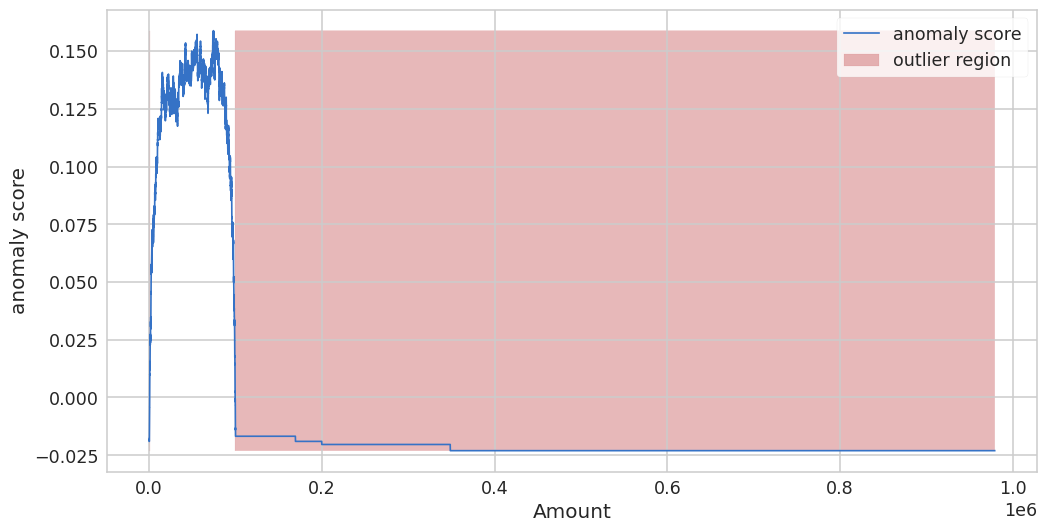

In [25]:
xx = np.linspace(df['Amount'].min(), df['Amount'].max(), len(df)).reshape(-1,1)
anomaly_score = Amount_ifmodel.decision_function(xx)
outlier = Amount_ifmodel.predict(xx)
plt.figure(figsize=(12, 6))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                 where=outlier==-1, color='r',
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Amount');

### Filter and Sort Outliers

Here we predict outliers in our dataset using our trained model and filter out the outlier observations and sort by descending order and view the top 5 outlier values

In [26]:
outlier_predictions = Amount_ifmodel.predict(df[['Amount']])

amount_outliers_df = df[['Amount']]
amount_outliers_df['Outlier'] = outlier_predictions
amount_outliers_df = amount_outliers_df[amount_outliers_df['Outlier'] == -1]['Amount']

print('Total Amount Outliers:', len(amount_outliers_df))
amount_outliers_sorted = amount_outliers_df.sort_values(ascending=False)
amount_outliers_sorted.head(5)

Total Amount Outliers: 2170


,Amount
2775,978942.26
45100,873004.79
3448,712076.97
213460,689504.90
211959,616155.70


### View Top 10 Outlier Transactions

In [27]:
(df.loc[amount_outliers_sorted.index.tolist()][['TransactionID', 'AccountID', 'Merchant', 'TransactionType', 'Location']]).head(10)

,TransactionID,AccountID,Merchant,TransactionType,Location
2775,TXN1049,ACC14,MerchantJ,Transfer,New York
45100,TXN190,ACC5,MerchantI,Withdrawal,Los Angeles
3448,TXN827,ACC12,MerchantA,Withdrawal,Tokyo
213460,TXN1249,ACC5,MerchantI,Purchase,San Francisco
211959,TXN1359,ACC8,MerchantC,Purchase,New York
3453,TXN1690,ACC8,MerchantF,Purchase,Tokyo
4194,TXN667,ACC3,MerchantE,Transfer,Los Angeles
211753,TXN141,ACC4,MerchantG,Withdrawal,San Francisco
211866,TXN543,ACC2,MerchantJ,Purchase,San Francisco
4148,TXN625,ACC1,MerchantD,Purchase,San Francisco


### View Bottom 10 Outlier Transactions

In [28]:
(df.loc[amount_outliers_sorted.index.tolist()][['TransactionID', 'AccountID', 'Merchant', 'TransactionType', 'Location']]).tail(10)

,TransactionID,AccountID,Merchant,TransactionType,Location
109623,TXN1838,ACC1,MerchantE,Withdrawal,London
214887,TXN898,ACC11,MerchantH,Withdrawal,New York
6222,TXN1082,ACC12,MerchantI,Withdrawal,Tokyo
9891,TXN1585,ACC12,MerchantF,Transfer,London
674,TXN1854,ACC9,MerchantI,Withdrawal,Tokyo
69244,TXN880,ACC11,MerchantG,Purchase,Los Angeles
13080,TXN236,ACC9,MerchantD,Transfer,San Francisco
123095,TXN1115,ACC9,MerchantD,Withdrawal,Los Angeles
140880,TXN1618,ACC12,MerchantB,Purchase,New York
196116,TXN1805,ACC1,MerchantD,Purchase,London


# 4. Multivariate Anomaly Detection

Multivariate is basically analysis done on more than one attribute or feature at a time. In this section, we will perform anomaly detection on two attributes (__`Discount`__ & __`Profit`__) using the following methods.

- Clustering Based Local Outlier Factor (CBLOF)
- Isolation Forest
- Auto-Encoders

You will learn how to train these models to detect outliers and also visualize these outliers. For this section we will be using the __[`pyod`](https://pyod.readthedocs.io/en/latest/)__ package so make sure you have it installed.

In [29]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=c0dc7d2aa1385ae4b3295be07a551c566db78c5f8864fb4dd8bca022b6322dd3
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


## Extract Subset Data for Outlier Detection

In [132]:
cols = ['Amount', 'TransactionType']
subset_df = df[cols]
subset_df.head()

,Amount,TransactionType
0,95071.92,Purchase
1,15607.89,Purchase
2,65092.34,Withdrawal
3,87.87,Purchase
4,716.56,Purchase


In [133]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

label_encoders = {}
# TransactionType Label Encoder
for col in ['TransactionType']:
    le = LabelEncoder()
    subset_df[col] = le.fit_transform(subset_df[col])
    label_encoders[col] = le
subset_df.head()

,Amount,TransactionType
0,95071.92,0
1,15607.89,0
2,65092.34,2
3,87.87,0
4,716.56,0


## Feature Scaling

In [134]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler(feature_range=(0, 1))
subset_df[cols] = mms.fit_transform(subset_df)
subset_df.head()

,Amount,TransactionType
0,0.097107,0.0
1,0.015933,0.0
2,0.066482,1.0
3,0.000079,0.0
4,0.000721,0.0


## 4.1: Multivariate Anomaly Detection with Clustering Based Local Outlier Factor (CBLOF)

The CBLOF model takes as an input the dataset and the cluster model that was generated by a clustering algorithm. It classifies the clusters into small clusters and large clusters using the parameters alpha and beta. The anomaly score is then calculated based on the size of the cluster the point belongs to as well as the distance to the nearest large cluster.

By default, kMeans is used for clustering algorithm. You can read more in the [official documentation](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cblof)

### Initialize and Train Model

Here we initialize the CBLOF model with some hyperparameters assuming the proportion of outliers to be 1% of the total data (using the `contamination` setting)

In [92]:
from pyod.models import cblof

cblof_model = cblof.CBLOF(contamination=0.01, random_state=42)
cblof_model.fit(subset_df)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.01, n_clusters=8, n_jobs=None, random_state=42,
   use_weights=False)

### Filter and Sort Outliers

Here we predict outliers in our dataset using our trained model and filter out the outlier observations and sort by descending order and view the top 5 outlier values

In [93]:
outlier_predictions = cblof_model.predict(subset_df)

outliers_df = subset_df.copy(deep=True)
outliers_df['Outlier'] = outlier_predictions
outliers_df = outliers_df[outliers_df['Outlier'] == 1]

print('Total Outliers:', len(outliers_df))
outliers_sorted_cblof = outliers_df.sort_values(by=['Amount', 'TransactionType'], ascending=False)

Total Outliers: 2170


### View Top 10 Outlier Transactions

In [94]:
(df.loc[outliers_sorted_cblof.index.tolist()][['TransactionID', 'AccountID', 'Merchant', 'TransactionType', 'Location']]).head(10)

,TransactionID,AccountID,Merchant,TransactionType,Location
2775,TXN1049,ACC14,MerchantJ,Transfer,New York
45100,TXN190,ACC5,MerchantI,Withdrawal,Los Angeles
3448,TXN827,ACC12,MerchantA,Withdrawal,Tokyo
213460,TXN1249,ACC5,MerchantI,Purchase,San Francisco
211959,TXN1359,ACC8,MerchantC,Purchase,New York
3453,TXN1690,ACC8,MerchantF,Purchase,Tokyo
4194,TXN667,ACC3,MerchantE,Transfer,Los Angeles
211753,TXN141,ACC4,MerchantG,Withdrawal,San Francisco
211866,TXN543,ACC2,MerchantJ,Purchase,San Francisco
4148,TXN625,ACC1,MerchantD,Purchase,San Francisco


### View Bottom 10 Outlier Transactions

In [95]:
(df.loc[outliers_sorted_cblof.index.tolist()][['TransactionID', 'AccountID', 'Merchant', 'TransactionType', 'Location']]).tail(10)

,TransactionID,AccountID,Merchant,TransactionType,Location
150621,TXN587,ACC14,MerchantD,Purchase,Los Angeles
162998,TXN398,ACC6,MerchantC,Purchase,San Francisco
31271,TXN288,ACC13,MerchantA,Purchase,London
35406,TXN703,ACC10,MerchantH,Purchase,Los Angeles
137440,TXN1719,ACC10,MerchantJ,Purchase,San Francisco
39439,TXN272,ACC13,MerchantG,Purchase,San Francisco
64758,TXN1352,ACC2,MerchantA,Purchase,San Francisco
69244,TXN880,ACC11,MerchantG,Purchase,Los Angeles
140880,TXN1618,ACC12,MerchantB,Purchase,New York
196116,TXN1805,ACC1,MerchantD,Purchase,London


We can definitely see some huge losses incurred based on giving higher discounts even if the sales amount was high which is interesting as well as concerning.

## Q 4.2: Multivariate Anomaly Detection with Isolation Forest

Here you will detect anomalies using the Isolation Forest model and use the learnings from 4.1. Here you will use the [`pyod`](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest) version of [Isolation Forest](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest) which is basically a wrapper over the `scikit-learn` version but with more functionalities.

### Initialize and Train Model

__Your Turn:__ Initialize the isolation forest model with similar hyperparameters as before and also assuming the proportion of outliers to be 1% of the total data (using the contamination setting)

In [47]:
from pyod.models import iforest

# Initialize the Isolation Forest model
if_model = iforest.IForest(contamination=0.01, random_state=42)

# Fit the model to the subset dataframe
if_model.fit(subset_df)

IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=42, verbose=0)

### Filter and Sort Outliers

__Your Turn:__ Predict outliers in our dataset using our trained model and filter out the outlier observations and sort by descending order and view the top 5 outlier values similar to 4.1

In [48]:
# Predict outliers in the dataset
outlier_predictions_if = if_model.predict(subset_df)

# Create a copy of the subset dataframe and add outlier predictions
outliers_df_if = subset_df.copy(deep=True)
outliers_df_if['Outlier'] = outlier_predictions_if

# Filter the dataframe for outliers
outliers_df_if = outliers_df_if[outliers_df_if['Outlier'] == 1]

# Display the total number of outliers
print('Total Outliers:', len(outliers_df_if))

# Sort the outliers by Amount in descending order
outliers_sorted_if = outliers_df_if.sort_values(by=['Amount'], ascending=False)

Total Outliers: 2140


### View Top 10 Outlier Transactions

In [52]:
(df.loc[outliers_sorted_if.index.tolist()][['TransactionID', 'AccountID', 'Merchant', 'TransactionType', 'Location']]).head(10)

,TransactionID,AccountID,Merchant,TransactionType,Location
45100,TXN190,ACC5,MerchantI,Withdrawal,Los Angeles
3448,TXN827,ACC12,MerchantA,Withdrawal,Tokyo
213460,TXN1249,ACC5,MerchantI,Purchase,San Francisco
211959,TXN1359,ACC8,MerchantC,Purchase,New York
3453,TXN1690,ACC8,MerchantF,Purchase,Tokyo
211753,TXN141,ACC4,MerchantG,Withdrawal,San Francisco
211866,TXN543,ACC2,MerchantJ,Purchase,San Francisco
4148,TXN625,ACC1,MerchantD,Purchase,San Francisco
212513,TXN1183,ACC7,MerchantH,Purchase,San Francisco
211714,TXN1920,ACC5,MerchantB,Purchase,New York


### View Bottom 10 Outlier Transactions

__Your turn:__ View the bottom ten transactions

In [53]:
(df.loc[outliers_sorted_if.index.tolist()][['TransactionID', 'AccountID', 'Merchant', 'TransactionType', 'Location']]).tail(10)

,TransactionID,AccountID,Merchant,TransactionType,Location
39439,TXN272,ACC13,MerchantG,Purchase,San Francisco
64758,TXN1352,ACC2,MerchantA,Purchase,San Francisco
109623,TXN1838,ACC1,MerchantE,Withdrawal,London
214887,TXN898,ACC11,MerchantH,Withdrawal,New York
6222,TXN1082,ACC12,MerchantI,Withdrawal,Tokyo
674,TXN1854,ACC9,MerchantI,Withdrawal,Tokyo
69244,TXN880,ACC11,MerchantG,Purchase,Los Angeles
123095,TXN1115,ACC9,MerchantD,Withdrawal,Los Angeles
140880,TXN1618,ACC12,MerchantB,Purchase,New York
196116,TXN1805,ACC1,MerchantD,Purchase,London


### Q: Do you notice any differences in the results with the previous model?

In [96]:
outliers_sorted_cblof

,Amount,TransactionType,Outlier
2775,1.000000e+00,0.5,1
45100,8.917826e-01,1.0,1
3448,7.273913e-01,1.0,1
213460,7.043335e-01,0.0,1
211959,6.294057e-01,0.0,1
...,...,...,...
39439,2.952198e-06,0.0,1
64758,2.635526e-06,0.0,1
69244,3.473174e-07,0.0,1
140880,1.838739e-07,0.0,1


In [71]:
outliers_sorted_if

,Amount,TransactionType,Outlier
45100,8.917826e-01,1.0,1
3448,7.273913e-01,1.0,1
213460,7.043335e-01,0.0,1
211959,6.294057e-01,0.0,1
3453,5.000163e-01,0.0,1
...,...,...,...
674,6.639891e-07,1.0,1
69244,3.473174e-07,0.0,1
123095,1.940891e-07,1.0,1
140880,1.838739e-07,0.0,1


We do notice some transactions with 80% discount and high losses

## 4.4: Visualize Anomalies and Compare Anomaly Detection Models

Here we will look at the visual plots of anomalies as detected by the above three models

In [88]:
def visualize_anomalies(model, xx, yy, data_df, ax_obj, subplot_title):

    # predict raw anomaly score
    scores_pred = model.decision_function(data_df) * -1
    # prediction of a datapoint category outlier or inlier
    y_pred = model.predict(data_df)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)


    out_df = data_df.copy(deep=True)
    out_df['Outlier'] = y_pred.tolist()
    # discount - inlier feature 1,  profit - inlier feature 2
    inliers_discount = out_df[out_df['Outlier'] == 0]['Amount'].values
    inliers_profit = out_df[out_df['Outlier'] == 0]['TransactionType'].values
    # discount - outlier feature 1, profit - outlier feature 2
    outliers_discount = out_df[out_df['Outlier'] == 1]['Amount'].values
    outliers_profit = out_df[out_df['Outlier'] == 1]['TransactionType'].values

    # Use threshold value to consider a datapoint inlier or outlier
    # threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    threshold = np.percentile(scores_pred, 100 * outliers_fraction)
    # decision function calculates the raw anomaly score for every point
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    # fill blue map colormap from minimum anomaly score to threshold value
    ax_obj.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
    # draw red contour line where anomaly score is equal to thresold
    a = ax_obj.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    ax_obj.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
    b = ax_obj.scatter(inliers_discount, inliers_profit, c='white',s=20, edgecolor='k')
    c = ax_obj.scatter(outliers_discount, outliers_profit, c='black',s=20, edgecolor='k')


    ax_obj.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
               prop=matplotlib.font_manager.FontProperties(size=10),loc='upper right')

    ax_obj.set_xlim((0, 1))
    ax_obj.set_ylim((0, 1))
    ax_obj.set_xlabel('Amount')
    ax_obj.set_ylabel('TransactionType')
    ax_obj.set_title(subplot_title)

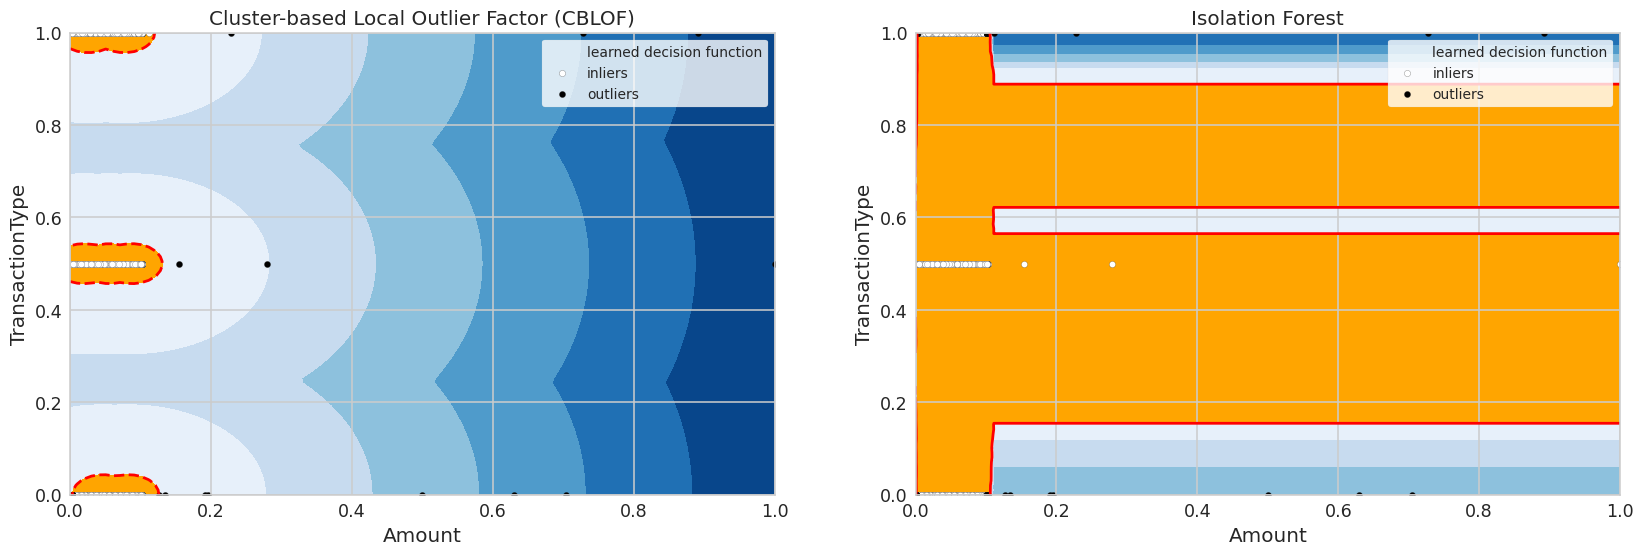

In [89]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax_objs = [ax[0], ax[1]]
models = [cblof_model, if_model]
plot_titles = ['Cluster-based Local Outlier Factor (CBLOF)',
               'Isolation Forest']

for ax_obj, model, plot_title in zip(ax_objs, models, plot_titles):
    visualize_anomalies(model=model,
                        xx=xx, yy=yy,
                        data_df=subset_df,
                        ax_obj=ax_obj,
                        subplot_title=plot_title)
plt.axis('tight');


# Rule-Based Anomaly (RBML)

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [98]:
# Extract Subset Data for Outlier Detection
cols = ['Amount', 'TransactionType']
subset_df = df[cols]

# TransactionType Label Encoder
label_encoders = {}
for col in ['TransactionType']:
    le = LabelEncoder()
    subset_df[col] = le.fit_transform(subset_df[col])
    label_encoders[col] = le

# Feature Scaling
mms = MinMaxScaler(feature_range=(0, 1))
subset_df[cols] = mms.fit_transform(subset_df)

In [99]:
# Rule-Based Anomaly Detection
def classify_anomalies(data):
    # Define thresholds for Amount and TransactionType
    amount_threshold = 0.8  # Example threshold for Amount
    transaction_type_threshold = 0.5  # Example threshold for TransactionType

    # Create a new column for Outlier classification
    conditions = [
        (data['Amount'] > amount_threshold) & (data['TransactionType'] > transaction_type_threshold)
    ]
    choices = [1]  # 1 for Outlier
    data['Outlier'] = np.select(conditions, choices, default=0)  # 0 for Inlier
    return data

In [100]:
# Classify anomalies
outliers_df = classify_anomalies(subset_df)

# Filter and Sort Outliers
outliers_df = outliers_df[outliers_df['Outlier'] == 1]

print('Total Outliers:', len(outliers_df))
outliers_sorted_rule_based = outliers_df.sort_values(by=['Amount', 'TransactionType'], ascending=False)

# View Top 10 Outlier Transactions
top_outliers = df.loc[outliers_sorted_rule_based.index.tolist()][['TransactionID', 'AccountID', 'Merchant', 'TransactionType', 'Location']].head(10)
print("Top 10 Outlier Transactions:\n", top_outliers)

# View Bottom 10 Outlier Transactions
bottom_outliers = df.loc[outliers_sorted_rule_based.index.tolist()][['TransactionID', 'AccountID', 'Merchant', 'TransactionType', 'Location']].tail(10)
print("Bottom 10 Outlier Transactions:\n", bottom_outliers)

Total Outliers: 1
Top 10 Outlier Transactions:
       TransactionID AccountID   Merchant TransactionType     Location
45100        TXN190      ACC5  MerchantI      Withdrawal  Los Angeles
Bottom 10 Outlier Transactions:
       TransactionID AccountID   Merchant TransactionType     Location
45100        TXN190      ACC5  MerchantI      Withdrawal  Los Angeles


In [103]:
!pip install pyod

# Artificial Immune System

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import pairwise_distances  # Importing pairwise_distances


# Simplified AIS implementation
class SimpleAIS:
    def __init__(self, affinity_threshold=0.1, num_detectors=5):
        self.affinity_threshold = affinity_threshold
        self.num_detectors = num_detectors
        self.detectors = []

    def fit(self, data):
        # Randomly select initial antibodies from the dataset
        for _ in range(self.num_detectors):
            self.detectors.append(data.sample().values[0])

    def predict(self, data):
        predictions = []
        distances = pairwise_distances(data, self.detectors)
        for distance in distances:
            # Check if the minimum distance to any detector is above the threshold
            if np.min(distance) > self.affinity_threshold:
                predictions.append(1)  # Anomaly
            else:
                predictions.append(0)  # Inlier
        return predictions

In [128]:
# Initialize and Train Simple AIS Model
ais_model = SimpleAIS(affinity_threshold=0.1, num_detectors=3)
ais_model.fit(subset_df)

# Make predictions
outlier_predictions = ais_model.predict(subset_df)

# Filter and Sort Outliers
outliers_df = subset_df.copy(deep=True)
outliers_df['Outlier'] = outlier_predictions
outliers_df = outliers_df[outliers_df['Outlier'] == 1]

print('Total Outliers:', len(outliers_df))
outliers_sorted_ais = outliers_df.sort_values(by=['Amount', 'TransactionType'], ascending=False)

# View Top 10 Outlier Transactions
top_outliers = df.loc[outliers_sorted_ais.index.tolist()][['Amount', 'TransactionType']].head(10)
print("Top Outlier Transactions:\n", top_outliers)

Total Outliers: 72240
Top Outlier Transactions:
            Amount TransactionType
2775    978942.26        Transfer
45100   873004.79      Withdrawal
3448    712076.97      Withdrawal
213460  689504.90        Purchase
211959  616155.70        Purchase
3453    489492.30        Purchase
4194    272990.11        Transfer
211753  223542.64      Withdrawal
211866  191561.95        Purchase
4148    187344.37        Purchase


In [129]:
outliers_sorted_ais

,Amount,TransactionType,Outlier
2775,1.000000e+00,0.666,1
45100,8.917826e-01,0.999,1
3448,7.273913e-01,0.999,1
213460,7.043335e-01,0.333,1
211959,6.294057e-01,0.333,1
...,...,...,...
39439,2.952198e-06,0.333,1
64758,2.635526e-06,0.333,1
69244,3.473174e-07,0.333,1
140880,1.838739e-07,0.333,1


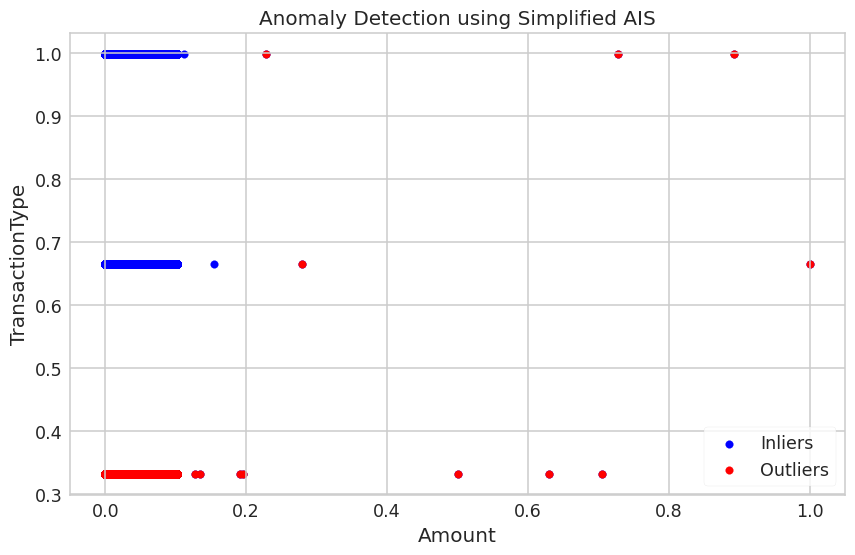

In [130]:
# Visualization of the results
plt.figure(figsize=(10, 6))
plt.scatter(subset_df['Amount'], subset_df['TransactionType'], c='blue', label='Inliers')
plt.scatter(outliers_sorted_ais['Amount'], outliers_sorted_ais['TransactionType'], c='red', label='Outliers')
plt.xlabel('Amount')
plt.ylabel('TransactionType')
plt.title('Anomaly Detection using Simplified AIS')
plt.legend()
plt.show()